<h2><center> Image Classification of Birds using the iNaturalist Dataset</center></h2>
<h3><center>Springboard | Capstone 2:   Data Wrangling and EDA </center></h3>
<h4><center>By: Lauren Broussard</center></h4>

First, we'll load the necessary packages, and import the iNaturalist annotations file so we can see more information about the labels and corresponding images. 

In this first stage, we will load and clean the entire dataset, to get a sense of it. However, in the interest of processing power, later we will train and test on just a subset of the full image data. 

In [1]:
# !pip install opencv-python  

In [2]:
#import necessary modules
import os
import cv2
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

%matplotlib inline

In [3]:
sns.set() # set graphs to follow seaborn default view

### DATA LOAD & MERGE

The dataset includes two separate annotation files in json format, which includes information about the image as well as its file path. We'll load both files and merge them, so we can create our own split later for training and testing (as opposed to the train/validation/test sets given by Kaggle). 

We'll first create a function to load each json file into a dataframe.

In [4]:
def annotations_loadmerge(ann_file):
    '''Function to load json annotations file and set up as dataframe'''
    
    # open and import file
    with open(ann_file) as data_file:
            anns = json.load(data_file)
   
    # create dataframe from json images and annotations keys
    anns_df = pd.DataFrame(anns['annotations'])[['image_id','category_id']]
    img_df = pd.DataFrame(anns['images'])[['id', 'file_name','height','width']].rename(columns={'id':'image_id'}) 
    
    
    # merge annotations and image dataframes 
    df = pd.merge(img_df, anns_df, on='image_id')
    
    
    # add column with wildlife_type indicator based on filename
    df['wildlife_type'] = df['file_name'].apply(lambda x: x.split("/")[1])
    
    # change category_id to string type
    df['category_id'] = df['category_id'].astype(str)

    # change category_id label to species_id
    df = df.rename(columns = {'category_id':'species_id'})
    
    return df

In [5]:
ann_file1 = '../data/raw/train2019.json'
ann_file2 = '../data/raw/val2019.json'

# run annotations_loadmerge function for each json file
df1 = annotations_loadmerge(ann_file1)
df2 = annotations_loadmerge(ann_file2)

In [6]:
# verify shape of dataframes 
print(df1.shape)
print(df2.shape)

(265213, 6)
(3030, 6)


Now, we'll merge these two dataframes into one.

In [7]:
# merge annotations and image dataframes 
df = pd.concat([df1, df2], axis=0)
df.set_index('image_id', inplace=True)

In [8]:
df.head()

file_name  height  width  \
image_id                                                                     
0         train_val2019/Plants/400/d1322d13ccd856eb4236c...     800    600   
1         train_val2019/Plants/570/15edbc1e2ef000d8ace48...     533    800   
2         train_val2019/Reptiles/167/c87a32e8927cbf4f06d...     600    800   
3         train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...     533    800   
4         train_val2019/Plants/739/ffa06f951e99de9d220ae...     600    800   

         species_id wildlife_type  
image_id                           
0               400        Plants  
1               570        Plants  
2               167      Reptiles  
3               254         Birds  
4               739        Plants

### DATA SUMMARY

We'll inspect our original annotation dataset to get a sense of the information we have available, and to run a quick check for missing values or duplicates.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268243 entries, 0 to 268242
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   file_name      268243 non-null  object
 1   height         268243 non-null  int64 
 2   width          268243 non-null  int64 
 3   species_id     268243 non-null  object
 4   wildlife_type  268243 non-null  object
dtypes: int64(2), object(3)
memory usage: 12.3+ MB


In [10]:
# check for duplicates
df[df.duplicated()]

Empty DataFrame
Columns: [file_name, height, width, species_id, wildlife_type]
Index: []

There are 268,243 images in our dataset, 1010 different species, and 6 different wildlife types or categories. 

In [11]:
df.nunique()

file_name        268243
height              591
width               516
species_id         1010
wildlife_type         6
dtype: int64

#### Wildlife Types & Species

The vast majority of images in the dataset (nearly 160,000) are of Plants, followed by Birds, Insects, then Reptiles and Amphibians, and finally Fungi. 

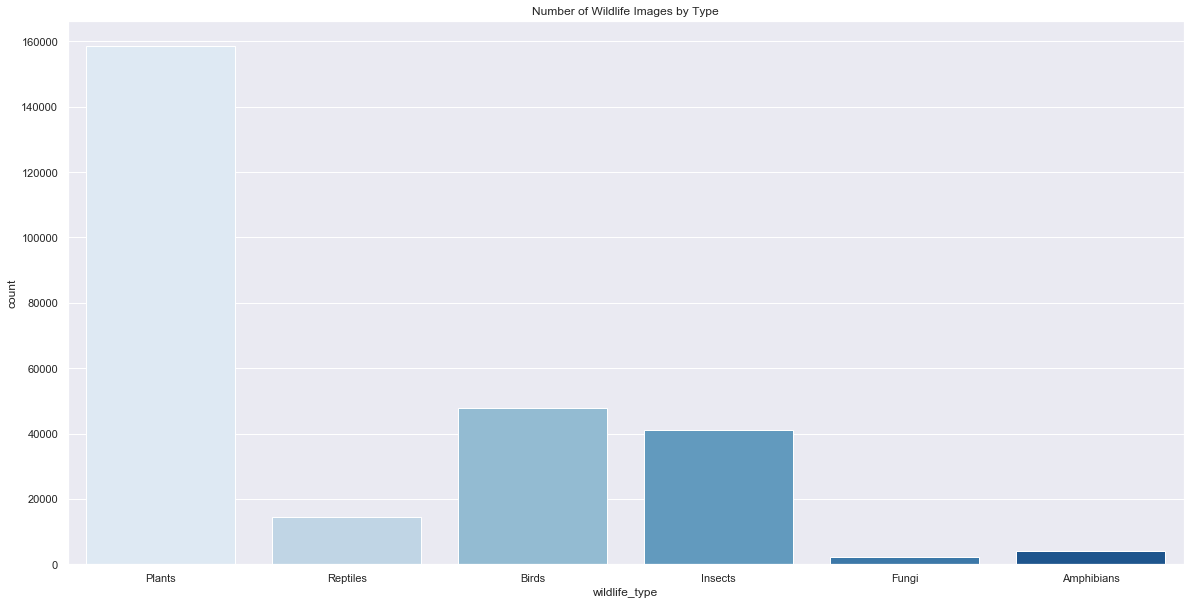

In [12]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
_ = sns.countplot('wildlife_type', data=df, palette='Blues')
_ = plt.title('Number of Wildlife Images by Type')

There are 47,867 images of birds in the entire dataset. 

In [13]:
len(df[df.wildlife_type == 'Birds'])

47867

In [14]:
# get each animal type and the number of unique species included within
df.groupby(['wildlife_type'])[['species_id']].nunique()

species_id
wildlife_type            
Amphibians             10
Birds                 126
Fungi                  12
Insects               141
Plants                682
Reptiles               39

There are 126 different type of bird species in the full dataset. As expected since it has the largest number of images, the Plants wildlife type also has the largest number of different species. 

#### Image Information: Pixel Height and Width

Each image has a maximum height and width of 800 pixels. The average height is approximately 663 pixels, while the average width is 720. Images in the dataset tend to be wider (horizontal) than they are tall (vertical). 

In [15]:
df.describe().T

count        mean         std    min    25%    50%    75%    max
height  268243.0  663.519074  121.247005  130.0  572.0  600.0  800.0  800.0
width   268243.0  720.694415  112.006142  188.0  600.0  800.0  800.0  800.0

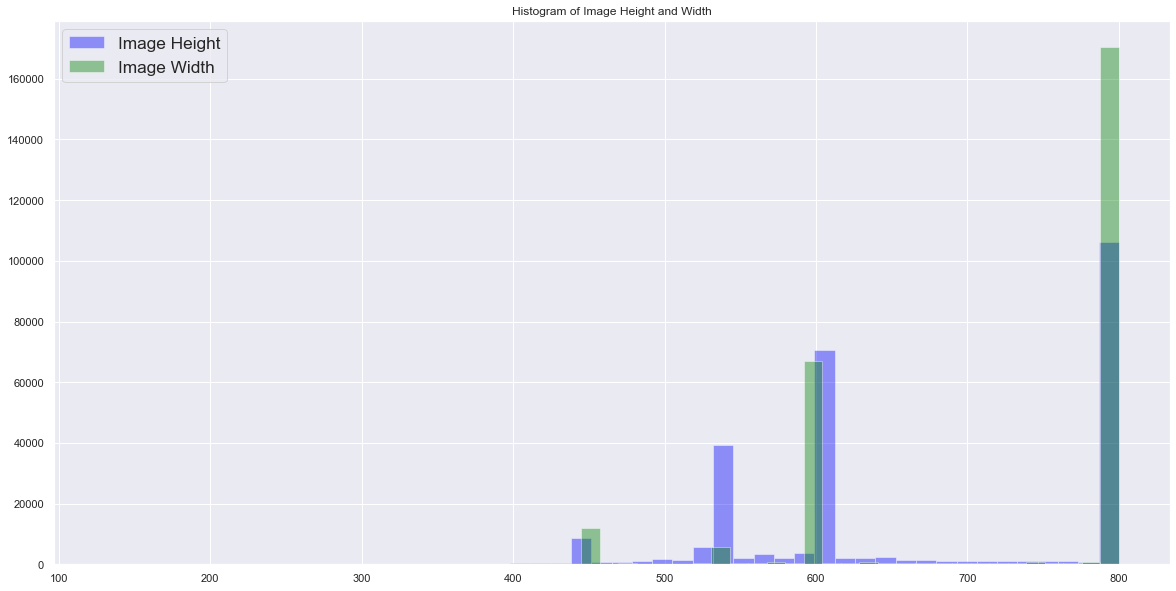

In [16]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

sns.distplot( df["height"] , color="blue", label="Image Height", kde=False)
sns.distplot( df["width"] , color="green", label="Image Width", kde=False)
_ = plt.xlabel('')
_ = plt.title('Histogram of Image Height and Width')
_ = plt.legend(fontsize='x-large')

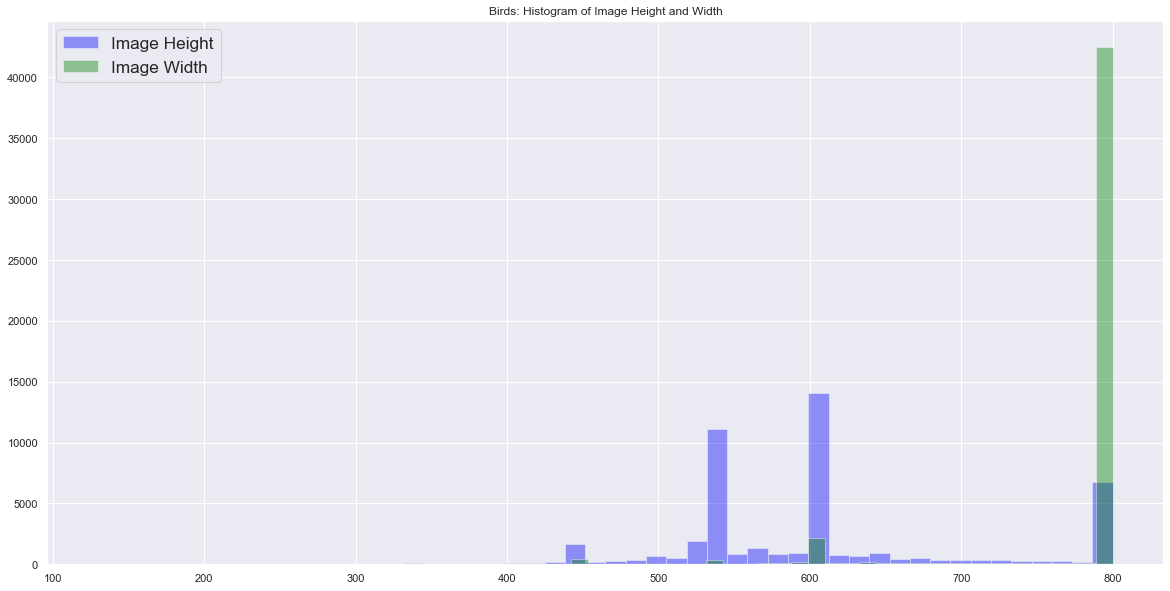

In [17]:
bird = df[df['wildlife_type'] == 'Birds']

fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

sns.distplot( bird["height"] , color="blue", label="Image Height", kde=False)
sns.distplot( bird["width"] , color="green", label="Image Width", kde=False)
_ = plt.xlabel('')
_ = plt.title('Birds: Histogram of Image Height and Width')
_ = plt.legend(fontsize='x-large')

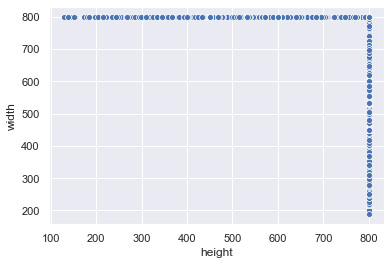

In [18]:
# look at breakdown of height vs width in images
_ = sns.scatterplot(df['height'],df['width'])

### VIEW SAMPLE IMAGES

Let's look at some sample images of each of the six types of wildlife. 

In [19]:
types = df['wildlife_type'].unique()

Plants


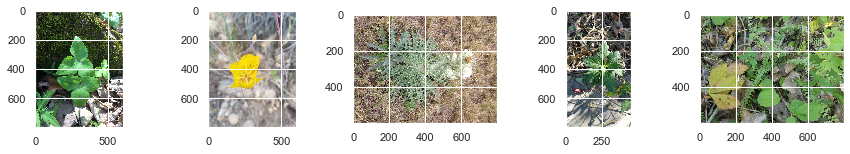

Reptiles


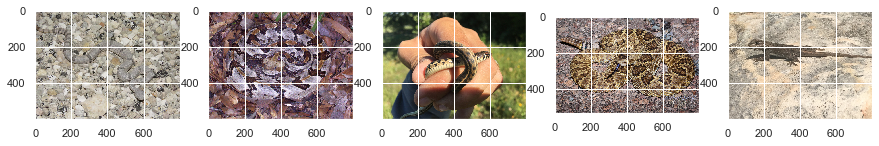

Birds


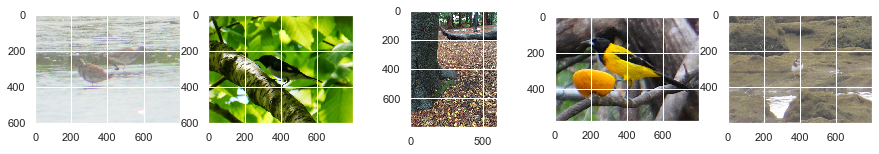

Insects


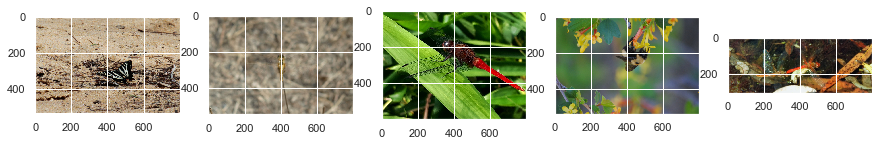

Fungi


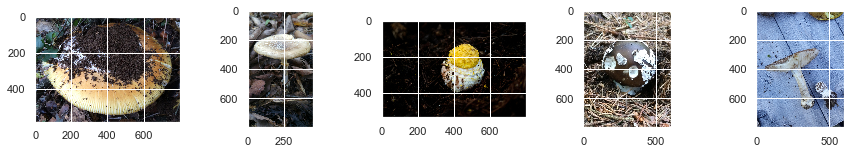

Amphibians


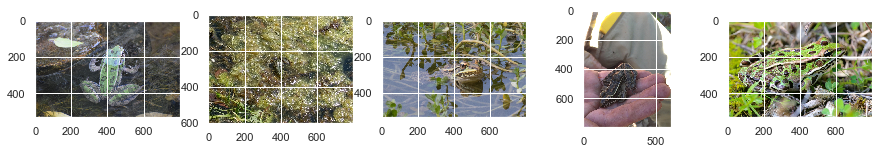

In [20]:
for type in types: 
    print(type)
    img_names = df[df['wildlife_type']== type ]['file_name'][300:305]
    plt.figure(figsize=[15,15])
    i = 1
    for img_name in img_names:
        img = cv2.imread("../data/raw/%s" % img_name)[...,[2, 1, 0]]
        plt.subplot(6, 5, i)
        plt.imshow(img)
        i += 1
    plt.show()

Many of the images are obscured in some way by other things since they are in their natural habitats. For instance, the amphibians are in water or are partly camoflauged in plants (another one of our categories). Being able to train a model that can distinguish between the two will be especially useful. 

#### Birds

Since our target is to classify birds, let's look at a few more images of birds in our dataset. 

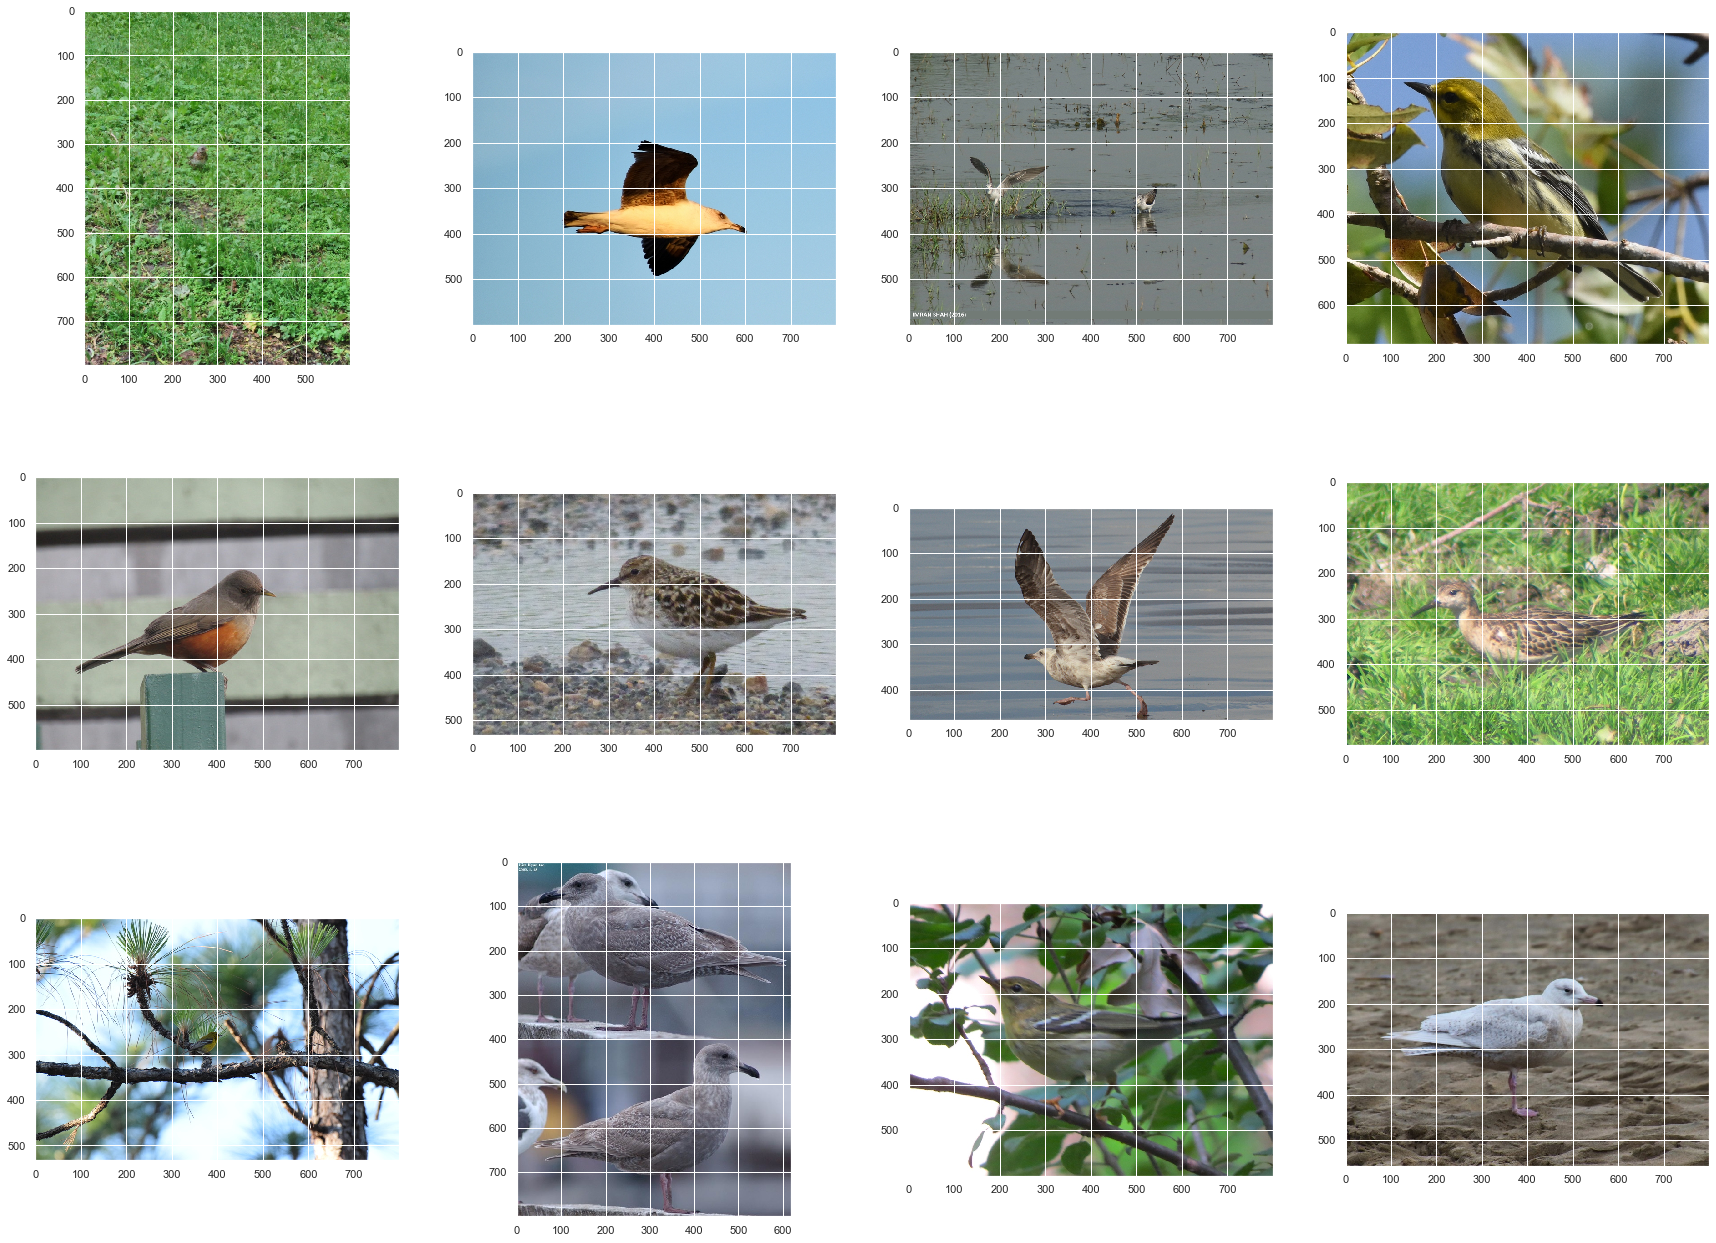

In [21]:
img_names = df[df['wildlife_type']== 'Birds' ]['file_name'][1000:1012]
plt.figure(figsize=[30,30])
i = 1
for img_name in img_names:
    img = cv2.imread("../data/raw/%s" % img_name)[...,[2, 1, 0]]
    plt.subplot(4, 4, i)
    plt.imshow(img)
    i += 1
plt.show()

### EXPORT

To get the file ready for export, we'll change the wildlife_type column into a numerical column we'll call type_num. 

We'll map the wildlife categories to type_num as follows: 

- 1 - Amphibians
- 2 - Birds
- 3 - Fungi
- 4 - Insects
- 5 - Plants
- 6 - Reptiles


In [22]:
mapping = {'Amphibians': 1, 'Birds': 2, 'Fungi': 3, 'Insects': 4, 'Plants': 5, 'Reptiles': 6}

#map wildlife_type to new column, wildlife_type
df['type_num'] = df['wildlife_type'].map(lambda s: mapping.get(s) if s in mapping else s)

In [23]:
df.groupby(['wildlife_type', 'type_num']).species_id.count()

wildlife_type  type_num
Amphibians     1             3912
Birds          2            47867
Fungi          3             2284
Insects        4            41204
Plants         5           158463
Reptiles       6            14513
Name: species_id, dtype: int64

Finally, we'll label which records contain images of birds, using a binary classification: 0: No Bird, 1: Bird. 

In [24]:
# create binary values for birds
df['is_bird'] = df['wildlife_type'].apply(lambda x: 1 if x  == 'Birds' else 0).astype(str)
df.head()

file_name  height  width  \
image_id                                                                     
0         train_val2019/Plants/400/d1322d13ccd856eb4236c...     800    600   
1         train_val2019/Plants/570/15edbc1e2ef000d8ace48...     533    800   
2         train_val2019/Reptiles/167/c87a32e8927cbf4f06d...     600    800   
3         train_val2019/Birds/254/9fcdd1d37e96d8fd94dfdc...     533    800   
4         train_val2019/Plants/739/ffa06f951e99de9d220ae...     600    800   

         species_id wildlife_type  type_num is_bird  
image_id                                             
0               400        Plants         5       0  
1               570        Plants         5       0  
2               167      Reptiles         6       0  
3               254         Birds         2       1  
4               739        Plants         5       0

Finally, we'll save our cleaned dataframe for use in our later analysis. 

In [25]:
# save to csv
df.to_csv('../data/interim/wildlife_interim.csv',index=False)

----

In [26]:
%load_ext watermark
%watermark -a "Lab 2.0" -d -t -v -p numpy,pandas

Lab 2.0 2020-09-29 19:25:53 

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
pandas 1.0.1
